### Project Overview
- You are required to analyze all of the Active Companies in the S&P 500
- Generate the Volatility of each company
- The market Cap of each company 
- The Expected Return of each company
- How does these companies tie into the Volatility market and what can we determine form this data

In [1]:
import pandas as pd
import numpy as np 
from pandas_datareader import data as web
import seaborn as sns

In [2]:
data = pd.read_csv("resources/companies.csv", index_col="Symbol")

## Data Overview
- There are 505 entries in the data set, but there my be conpanies that my not exist in the set so we will acount for them

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, MMM to ZTS
Data columns (total 2 columns):
Name      505 non-null object
Sector    505 non-null object
dtypes: object(2)
memory usage: 11.8+ KB


## Stock Data 
- We will import data previously generated pandas to get the stock data for each symbol in the list
- Will use data for the last 10 years if exists

In [4]:
stock_Data = pd.read_csv("resources/StockData.csv", parse_dates = True, index_col="Date")

### Companies that failed
- Either does not exist or cannot be fetched by yahoo data reader
- We have 485 companies Passed 
- 20 failed 
- This is a good number to move forward with our analysis

In [5]:
passed = pd.read_csv("resources/passed_Tickers.csv")

In [6]:
failed = pd.read_csv("resources/failed_tickers.csv")

In [7]:
data

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
AOS,A.O. Smith Corp,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie Inc.,Health Care
ACN,Accenture plc,Information Technology
...,...,...
XYL,Xylem Inc.,Industrials
YUM,Yum! Brands Inc,Consumer Discretionary
ZBH,Zimmer Biomet Holdings,Health Care


## Ramoving Failed Stocks
- Now working with 485 Stocks

In [8]:
data = data.drop(failed["failed"])

In [9]:
data

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
AOS,A.O. Smith Corp,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie Inc.,Health Care
ACN,Accenture plc,Information Technology
...,...,...
XYL,Xylem Inc.,Industrials
YUM,Yum! Brands Inc,Consumer Discretionary
ZBH,Zimmer Biomet Holdings,Health Care


### Calculating Volatility
- Calculating the Volatility for each Security

In [10]:
company_Vol= [stock_Data[x].pct_change().std() * np.sqrt(252) for x in stock_Data.dropna(axis = 1)]

In [11]:
len(company_Vol)

426

In [12]:
vol_for_period = pd.DataFrame(company_Vol, columns=["Vol"])

In [13]:
vol_for_period.index = stock_Data.dropna(axis=1).columns

In [14]:
vol_for_period.sort_values("Vol")

,Vol
JNJ,0.169479
KO,0.171567
PG,0.172565
PEP,0.174845
VZ,0.177242
...,...
FCX,0.512003
NFLX,0.520772
PCG,0.555253
AMD,0.579607


### Outlier
- Looks like there is one company disrupting the data set
- Let find that company and see if we should eliminate it
- looks like SCG is the issue- We will visit the web to make a decision on this company
- The Company is SCANA Corporation (SCG) 
- Loks like this company did not last long and the price dropped to 0 within a 1 year perios so we will eliminate it

In [15]:
stock_Data["SCG"].dropna()

Date
2015-07-16    1.018275e+26
2015-07-17    1.018275e+26
2015-07-20    1.018275e+26
2015-07-21    1.018275e+26
2015-07-22    1.018275e+26
                  ...     
2020-05-12    4.500000e-03
2020-05-13    4.500000e-03
2020-05-14    4.500000e-03
2020-05-15    4.500000e-03
2020-05-18    4.500000e-03
Name: SCG, Length: 1219, dtype: float64

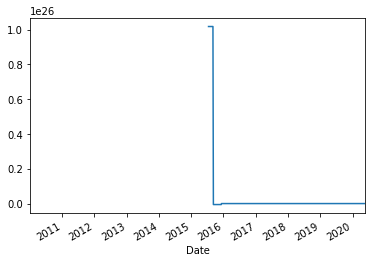

In [148]:
stock_Data["SCG"].plot()

### Volatility in order
- Beow we see the 20 most volatile stocks in order from highest to lowest

In [17]:
vol_for_period.sort_values("Vol", ascending = False).head(10)

,Vol
NKTR,0.579943
AMD,0.579607
PCG,0.555253
NFLX,0.520772
FCX,0.512003
RRC,0.507688
AAL,0.499022
MU,0.487764
FLR,0.484108
VRTX,0.483792


In [19]:
data.loc["ARNC"]

Name      Arconic Inc.
Sector     Industrials
Name: ARNC, dtype: object

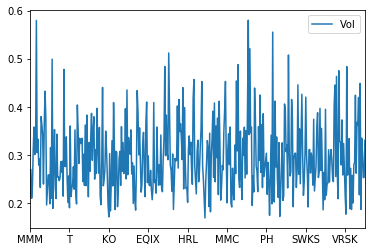

In [20]:
vol_for_period.plot()

In [21]:
vol_for_period.idxmax()

Vol    NKTR
dtype: object

### S&P Average Volatility
- From the list below we can that that most of the companies in the s&P have an average volatility around 25%

## Combining data
- Add the vol to the data set for the last 10 years of data

### S&P as a Portfolio 
- What would happen if we had a portfolio that consisted of every company since 2010. What coupanies would have earned us the highest retirns and a 200,000 investment weighted Arbritrarly over the period
- Also what if we optomized this portfolio using a Markowitz Portfolio Oprimization. What portfolio would earn us the highest return
- INvestment data will be 2010-1-04 as a start

## Calculate Normal Returns
- We will first need to eliminate all stocks that have no values on our initial investment dates. 
- Would be difficult to calculate the returns of each stock that would have been in our portfilio
- After droping all the null values we are ready to create our portfolio that will consist of 426 companies since 2010

In [24]:
portfolio_data = stock_Data.dropna(axis=1)

In [25]:
portfolio_data.isnull().sum()

MMM     0
AOS     0
ABT     0
ACN     0
ATVI    0
       ..
XRX     0
XLNX    0
YUM     0
ZBH     0
ZION    0
Length: 426, dtype: int64

In [26]:
port_Tickers = portfolio_data.columns

In [27]:
portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2612 entries, 2010-01-04 to 2020-05-19
Columns: 426 entries, MMM to ZION
dtypes: float64(426)
memory usage: 8.5 MB


### Normal Returns
- Calculating Normal Returns

In [28]:
for t in portfolio_data.columns:
    portfolio_data[f"{t} normal returns"] = portfolio_data[t]/portfolio_data[t].iloc[0]

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Allocations
- LEts consider how we would weigh each security in the portfolio
- Will randomize the Allocation for each security in the portfolio
- And make sure they will add up to 100% of the portflio

In [29]:
weii = np.random.random(426)
weights = weii/weii.sum()

In [30]:
weights.sum()

1.0

### Calculating Allocations with Weights

In [31]:
port_Allocaitons = pd.DataFrame()
for stock, weight in zip(port_Tickers,weights):
    portfolio_data[f"{stock} allocation"] = portfolio_data[f"{stock} normal returns"] * weight
    port_Allocaitons[f"{stock} allocation"] = portfolio_data[f"{stock} normal returns"] * weight
    

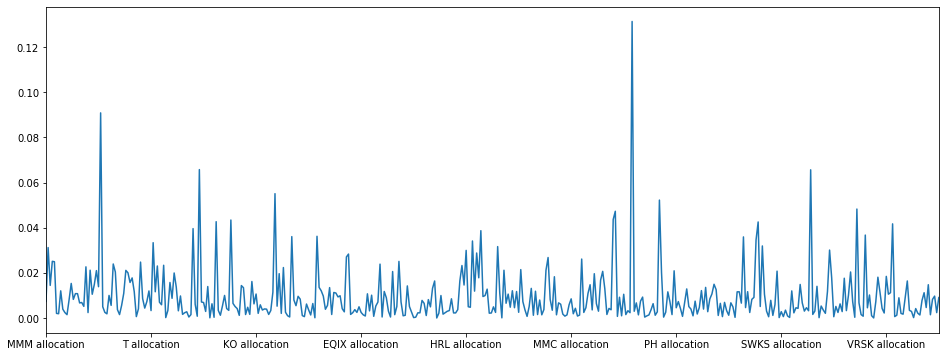

In [32]:
port_Allocaitons.loc["2020-5-19"].plot(figsize = (16,6))

### Leading Companies over a 10 year period 
- Top 20 companies that hold the most weight in the portfolio
- Netflix would have had the highest allocaton over a 10 year span 
- Again keep in mind that this is arbritrary values of weights 
- Further down we will take a look at 2000 different portfolios weighed randomly

In [33]:
port_Allocaitons.loc["2020-5-19"].sort_values(ascending = False).head(20)

NFLX allocation    0.131400
AMZN allocation    0.090897
CDNS allocation    0.065766
TTWO allocation    0.065673
STZ allocation     0.055098
NVDA allocation    0.052257
ULTA allocation    0.048284
MCO allocation     0.047298
MNST allocation    0.043664
CMG allocation     0.043421
CNC allocation     0.042687
ROST allocation    0.042562
V allocation       0.041722
AVGO allocation    0.039615
ILMN allocation    0.038701
UNH allocation     0.036754
DG allocation      0.036215
DHR allocation     0.036069
REGN allocation    0.035937
ROP allocation     0.034599
Name: 2020-05-19 00:00:00, dtype: float64

### Calculating Position Value 
- We will invest in the portfolio with a position of 200K

In [34]:
position = pd.DataFrame()
for x in port_Tickers:
    portfolio_data[f"{x} pos for stock"] = portfolio_data[f"{x} allocation"] * 200000
    position[f"{x} positon"] = portfolio_data[f"{x} allocation"] * 200000

In [35]:
len(position)

2612

#### Calculating total Position 
- Lets see the daily Total positon we hold for the period

In [36]:
portfolio_data["total positon"] = position.sum(axis = 1)

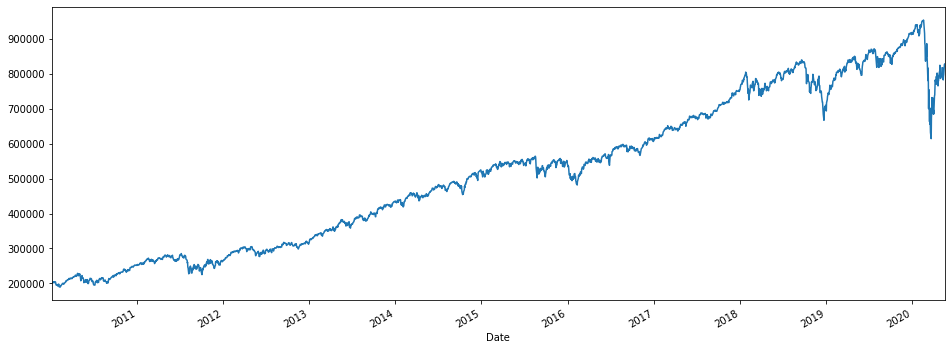

In [37]:
portfolio_data["total positon"].plot(figsize = (16,6))

### Highest Portfolio Position 
- would Have been on first day below 

In [38]:
portfolio_data["total positon"].sort_values(ascending = False)

Date
2020-02-19    953361.070296
2020-02-20    952126.806337
2020-02-14    950739.531503
2020-02-18    949148.593390
2020-02-13    948717.647428
                  ...      
2010-02-09    191832.814312
2010-02-10    191363.850467
2010-02-05    190720.633489
2010-02-04    190415.193670
2010-02-08    189546.823027
Name: total positon, Length: 2612, dtype: float64

### Calculating Daily Portfolio Returns
- We see our portfolio Volatility below
- Vol increase in 2010, late 2011, late 2015,early 2018, 2019 and recent 2020(COVID 19 epedemic)
- for from a educated guess since all companies in this portfolio makes up the S&P the overall/average vol should be close to that of the entire index. We will analyze this later

In [39]:
portfolio_data["daily returns"] = portfolio_data["total positon"].pct_change()

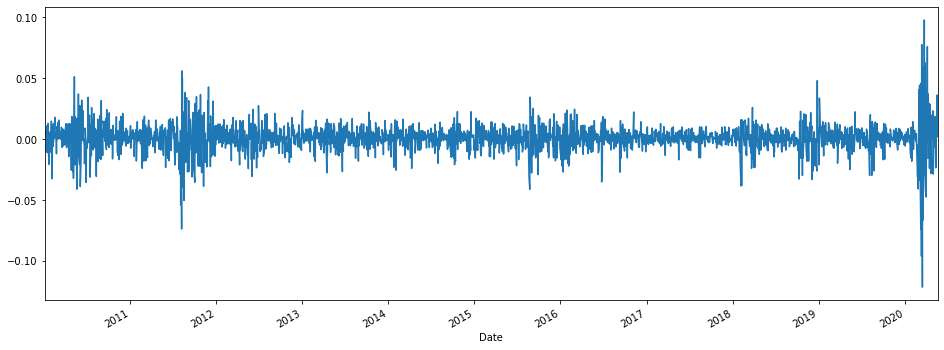

In [40]:
portfolio_data["daily returns"].plot(figsize = (16,6))

## Sharp Ratio
- Since we have the daily returns and the for the Portfilio we can calculate the Sharp Ratio for the portfilio

In [41]:
volatility = portfolio_data["daily returns"].std()

In [42]:
volatility

0.011427577089088556

In [43]:
mean_daily_return = portfolio_data["daily returns"].mean()

In [44]:
mean_daily_return

0.0006096545744186931

In [45]:
sharp = (mean_daily_return/volatility) * np.sqrt(252)

### Sharp Results
- We get at pretty low sharp ratio for this portfolio 
- This is the outcome of having some really volatilie companies and some not 
- Keep in mind this is again using arbritrary Weights 
- We will use markowitz portfolio optimiztion on this portfolio to see what is the max sharp we could get from this portfolio

In [46]:
sharp

0.8468957384351885

### Random Allocation of weights
- We will assign 2000 portfolios with random weights to try to get the max sharp

In [47]:
port_Tickers

Index(['MMM', 'AOS', 'ABT', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AAP', 'AMD', 'AES',
       ...
       'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'YUM', 'ZBH',
       'ZION'],
      dtype='object', length=426)

In [48]:
port_daily_returns = stock_Data.dropna(axis = 1).pct_change()

#### Importing 2000 portfolios 
- Import associatied Weights
- Lowest Vol, Max Return, Max Sharp
- Calculations are commented out below

In [49]:
all_portfolios = pd.read_csv("resources/random_Allocations_DF.csv", index_col="Unnamed: 0")

In [50]:
all_Weights = pd.read_csv("resources/just_weights.csv", index_col="Unnamed: 0")

In [51]:
##number_of_ports = 2000
##all_weights = np.zeros((number_of_ports, len(port_Tickers)))
##all_vol = np.zeros(number_of_ports)
##all_returns = np.zeros(number_of_ports)
##all_sharps = np.zeros(number_of_ports)

##for ind in range(number_of_ports):
    ##weights = np.random.random(len(port_Tickers))
    ##weights = weights/weights.sum()
    ##all_weights[ind,:] = weights
    
    ##all_returns[ind] = np.sum(port_daily_returns.mean() *weights) * 252 
    ##all_vol[ind] = np.sqrt(np.dot(weights.T, np.dot(port_daily_returns.cov() * 252, weights)))
    ##all_sharps[ind] = all_returns[ind]/all_vol[ind]

### Capturing Metrics
- Will look at the Max Sharp
- Lowest Vol
- Highest Return

In [52]:
all_portfolios.columns

Index(['Sharps', 'all Vols', 'all_returns', 'MMM', 'AOS', 'ABT', 'ACN', 'ATVI',
       'AYI', 'ADBE',
       ...
       'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'YUM', 'ZBH',
       'ZION'],
      dtype='object', length=429)

In [53]:
max_sharp = all_portfolios["Sharps"].argmax()

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


In [54]:
max_sharp

213

In [55]:
max_returns = all_portfolios["all_returns"].argmax()

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


In [56]:
max_returns

213

In [57]:
lowest_vol =all_portfolios["all Vols"].argmin()

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [58]:
lowest_vol

834

### Plotting the All portfolios

In [59]:
import matplotlib.pyplot as plt

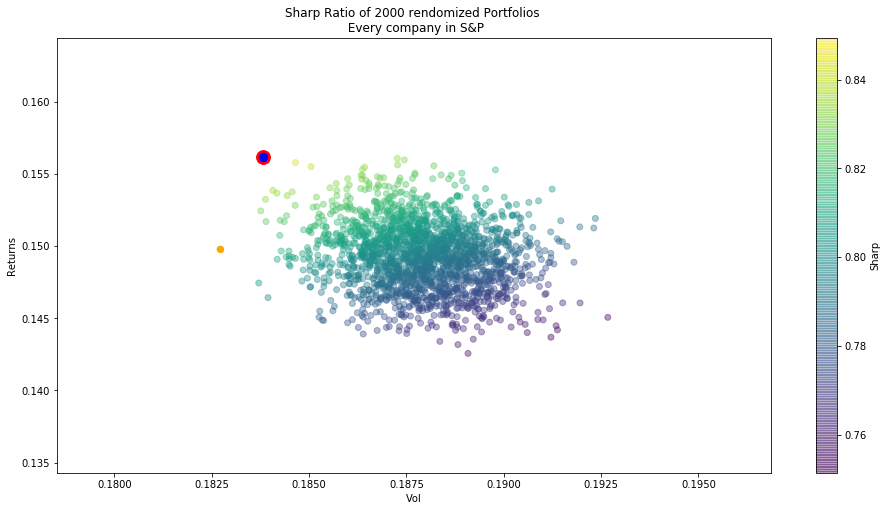

In [60]:
plt.figure(figsize= (16,8))
plt.scatter(all_portfolios["all Vols"], all_portfolios["all_returns"], c = all_portfolios["Sharps"], alpha=0.4)
plt.colorbar(label = "Sharp")
plt.scatter(all_portfolios["all Vols"][max_sharp], all_portfolios["all_returns"][max_sharp], c = "r", s = 190, label = "Max Sharp")
plt.scatter(all_portfolios["all Vols"][lowest_vol], all_portfolios["all_returns"][lowest_vol], c = "orange", s = 40, label  = "Lowest Vol")
plt.scatter(all_portfolios["all Vols"][max_returns], all_portfolios["all_returns"][max_returns], c = "b", s = 70, label = "Max Returns")
plt.xlabel("Vol")
plt.ylabel("Returns")
plt.title("Sharp Ratio of 2000 rendomized Portfolios \n Every company in S&P");

### Observing  Portfolios and weights

In [61]:
all_portfolios[all_portfolios["Sharps"] == all_portfolios["Sharps"].max()]

,Sharps,all Vols,all_returns,MMM,AOS,ABT,ACN,ATVI,AYI,ADBE,...,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,YUM,ZBH,ZION
213,0.849394,0.183828,0.156142,0.004285,0.00313,0.002169,0.002197,0.003488,0.002639,0.003143,...,0.003783,0.003605,0.003951,0.000888,0.002099,0.001061,0.004136,0.000574,0.000576,0.000315


In [62]:
all_portfolios[all_portfolios["Sharps"] == all_portfolios["Sharps"].max()].transpose().drop(["Sharps"
                                        ,"all Vols", "all_returns"]).sort_values(213, ascending = False)

,213
KMB,0.004611
HRL,0.004606
RF,0.004590
WDC,0.004585
MSI,0.004579
...,...
ADS,0.000077
IVZ,0.000076
MAT,0.000066
PFE,0.000064


In [63]:
all_portfolios[all_portfolios["Sharps"] == all_portfolios["Sharps"].max()]

,Sharps,all Vols,all_returns,MMM,AOS,ABT,ACN,ATVI,AYI,ADBE,...,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,YUM,ZBH,ZION
213,0.849394,0.183828,0.156142,0.004285,0.00313,0.002169,0.002197,0.003488,0.002639,0.003143,...,0.003783,0.003605,0.003951,0.000888,0.002099,0.001061,0.004136,0.000574,0.000576,0.000315


In [64]:
max_returns_top_10 = all_portfolios[all_portfolios["Sharps"] == all_portfolios["Sharps"].max()].transpose().drop(["Sharps"
                                        ,"all Vols", "all_returns"]).sort_values(213, ascending = False).head(10)

In [65]:
max_returns_top_10

,213
KMB,0.004611
HRL,0.004606
RF,0.004590
WDC,0.004585
MSI,0.004579
DRE,0.004574
AMD,0.004574
KO,0.004556
NFLX,0.004535
NTAP,0.004523


In [66]:
all_portfolios[all_portfolios["all Vols"] == all_portfolios["all Vols"].min()].transpose().drop(["Sharps"
                                        ,"all Vols", "all_returns"]).sort_values(834, ascending = False).head(10)

,834
CF,0.004656
HSIC,0.004646
RF,0.004631
RSG,0.004630
IDXX,0.004615
FITB,0.004604
FISV,0.004571
MU,0.004564
MAA,0.004551
MAT,0.004548


### Portfolio with lowest Vol

In [67]:
all_portfolios[all_portfolios["all Vols"] == all_portfolios["all Vols"].min()].transpose().drop(["Sharps",
                        "all Vols", "all_returns"]).sort_values(834, ascending = False).head(20)

,834
CF,0.004656
HSIC,0.004646
RF,0.004631
RSG,0.004630
IDXX,0.004615
FITB,0.004604
FISV,0.004571
MU,0.004564
MAA,0.004551
MAT,0.004548


## Weights Visual For low Vol 
- Looks like there are some stocks that are almost 0 in weight at the end of a 10 year span

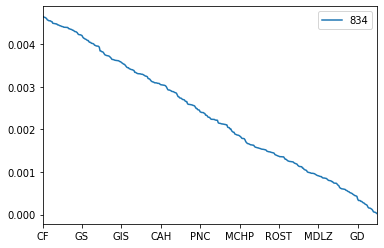

In [68]:
all_portfolios[all_portfolios["all Vols"] == all_portfolios["all Vols"].min()].transpose().drop(["Sharps",
                        "all Vols", "all_returns"]).sort_values(834, ascending = False).plot()

### Max Return 
- Portfolio that generates the max return
- In this case the max return and the max sharp is the same, as seen above, so will only run for the max return

In [72]:
all_portfolios[all_portfolios["all_returns"] == all_portfolios["all_returns"].max()].transpose().drop(["Sharps",
                        "all Vols", "all_returns"]).sort_values(213, ascending = False).head(20)

,213
KMB,0.004611
HRL,0.004606
RF,0.004590
WDC,0.004585
MSI,0.004579
DRE,0.004574
AMD,0.004574
KO,0.004556
NFLX,0.004535
NTAP,0.004523


### Volatility Analysis
- We will look at the volatility of each stock for a 10 year period
-  Our next project will be to create a neural network to forecast the next day price of 5 stocks with the lowest Vol
- Appears the J&J has the lowest Vol of companies that have been overating for the last 10 years

In [73]:
len(vol_for_period)

426

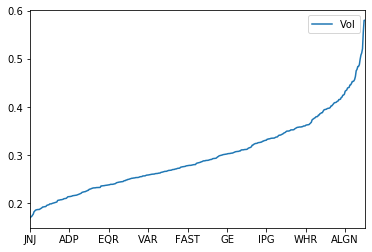

In [74]:
vol_for_period.sort_values("Vol").plot()

In [75]:
vol_for_period.sort_values("Vol")

,Vol
JNJ,0.169479
KO,0.171567
PG,0.172565
PEP,0.174845
VZ,0.177242
...,...
FCX,0.512003
NFLX,0.520772
PCG,0.555253
AMD,0.579607


# Max Return Portfolio

### Portfolio Optimization for the top 10 companies operating over a 10 year spand
 

In [76]:
tickers = list(max_returns_top_10.index)

In [77]:
tickers

['KMB', 'HRL', 'RF', 'WDC', 'MSI', 'DRE', 'AMD', 'KO', 'NFLX', 'NTAP']

In [78]:
portfolio = pd.DataFrame()

In [79]:
for t in tickers:
    portfolio[t] = web.DataReader(t, data_source="yahoo", start = "2010-1-1")["Adj Close"]

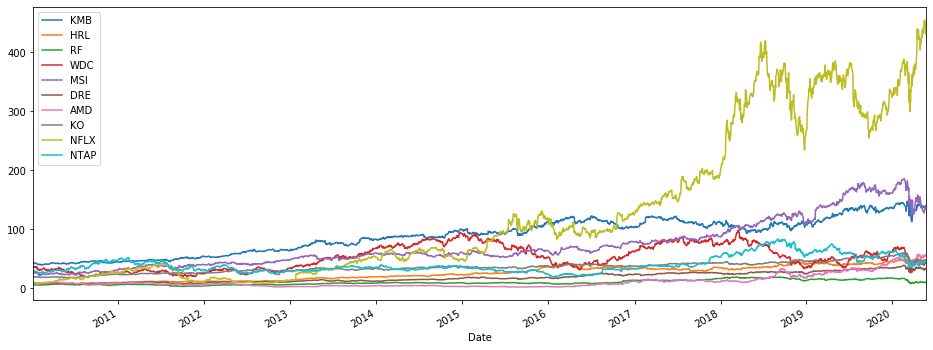

In [80]:
portfolio.plot(figsize = (16,6))

In [81]:
portfolio.head()

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP
Date,,,,,,,,,,
2010-01-04,42.999062,6.577104,4.467733,35.536190,27.119108,7.777900,9.70,19.292267,7.640000,29.236656
2010-01-05,43.032513,6.611470,4.616107,36.478378,26.744816,7.893508,9.71,19.058893,7.358572,28.723576
2010-01-06,42.503986,6.575389,4.673808,36.509796,27.119108,8.009115,9.57,19.052124,7.617143,28.518341
2010-01-07,42.222988,6.539307,5.085960,35.795292,27.663528,8.240336,9.47,19.004770,7.485714,28.449938
2010-01-08,41.955372,6.544460,5.094203,35.975883,26.404562,8.426594,9.43,18.653023,7.614286,28.680824


### NORMAL RETURNS

In [82]:
for x in tickers:
    portfolio[f"{x} normal returns"] = portfolio[f"{x}"]/portfolio[f"{x}"].iloc[0]

### ARBRITRARY WEIGHTS

In [83]:
weights = np.random.random(len(tickers))
weights = weights/weights.sum()

In [84]:
np.sum(weights)

1.0000000000000002

## ALLOCATIONS

In [85]:
for stock, weight in zip(tickers,weights):
    portfolio[f"{stock} allocation"] = portfolio[f"{x} normal returns"] * weight 

In [86]:
portfolio.head()

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP,...,KMB allocation,HRL allocation,RF allocation,WDC allocation,MSI allocation,DRE allocation,AMD allocation,KO allocation,NFLX allocation,NTAP allocation
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,42.999062,6.577104,4.467733,35.536190,27.119108,7.777900,9.70,19.292267,7.640000,29.236656,...,0.082302,0.056343,0.138180,0.125567,0.149146,0.148153,0.003467,0.080778,0.130300,0.085764
2010-01-05,43.032513,6.611470,4.616107,36.478378,26.744816,7.893508,9.71,19.058893,7.358572,28.723576,...,0.080858,0.055354,0.135755,0.123364,0.146529,0.145553,0.003406,0.079361,0.128013,0.084259
2010-01-06,42.503986,6.575389,4.673808,36.509796,27.119108,8.009115,9.57,19.052124,7.617143,28.518341,...,0.080280,0.054958,0.134785,0.122482,0.145482,0.144513,0.003382,0.078794,0.127098,0.083657
2010-01-07,42.222988,6.539307,5.085960,35.795292,27.663528,8.240336,9.47,19.004770,7.485714,28.449938,...,0.080087,0.054826,0.134461,0.122189,0.145133,0.144167,0.003374,0.078605,0.126793,0.083456
2010-01-08,41.955372,6.544460,5.094203,35.975883,26.404562,8.426594,9.43,18.653023,7.614286,28.680824,...,0.080737,0.055271,0.135553,0.123180,0.146311,0.145337,0.003401,0.079243,0.127822,0.084134


## POSITION 
- Taking a position of 50000

In [87]:
pos = pd.DataFrame()
for x in tickers:
    portfolio[f"{x} position"] = portfolio[f"{x} allocation"] * 50000
    pos[x] = portfolio[f"{x} allocation"] * 50000

In [88]:
portfolio.head()

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP,...,KMB position,HRL position,RF position,WDC position,MSI position,DRE position,AMD position,KO position,NFLX position,NTAP position
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,42.999062,6.577104,4.467733,35.536190,27.119108,7.777900,9.70,19.292267,7.640000,29.236656,...,4115.101562,2817.129495,6908.976730,6278.370895,7457.313325,7407.657045,173.355708,4038.918955,6514.975625,4288.200659
2010-01-05,43.032513,6.611470,4.616107,36.478378,26.744816,7.893508,9.71,19.058893,7.358572,28.723576,...,4042.884727,2767.691062,6787.729557,6168.190365,7326.443271,7277.658420,170.313450,3968.039066,6400.642866,4212.946070
2010-01-06,42.503986,6.575389,4.673808,36.509796,27.119108,8.009115,9.57,19.052124,7.617143,28.518341,...,4013.997671,2747.915468,6739.230147,6124.117661,7274.094666,7225.658390,169.096533,3939.686794,6354.909252,4182.843899
2010-01-07,42.222988,6.539307,5.085960,35.795292,27.663528,8.240336,9.47,19.004770,7.485714,28.449938,...,4004.369816,2741.324399,6723.065631,6109.428535,7256.647239,7208.327141,168.690943,3930.237179,6339.666556,4172.811054
2010-01-08,41.955372,6.544460,5.094203,35.975883,26.404562,8.426594,9.43,18.653023,7.614286,28.680824,...,4036.867418,2763.571713,6777.626903,6159.009814,7315.538812,7266.826571,170.059960,3962.133155,6391.116340,4206.675647


## Total Position 

In [89]:
portfolio["total position"] = pos.sum(axis = 1)

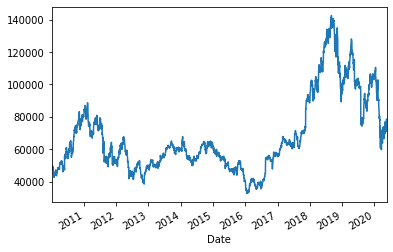

In [90]:
portfolio["total position"].plot()

# DAILY RETURNS

In [91]:
portfolio["daily returns"] = portfolio["total position"].pct_change()

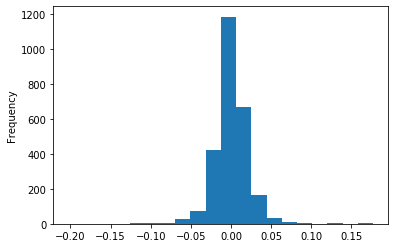

In [92]:
portfolio["daily returns"].plot(kind = "hist", bins = 20)

### Sharp

In [93]:
mean_daily_returns = portfolio["daily returns"].mean()

In [94]:
mean_daily_returns

0.0003953557386847007

In [95]:
vola = portfolio["daily returns"].std()

In [96]:
vola

0.021571101579183734

In [97]:
sharp = (mean_daily_returns/vola) * np.sqrt(252)

### Very low sharp 

In [98]:
sharp

0.2909484135862676

In [99]:
port_daily = portfolio[['KMB', 'HRL', 'RF', 'WDC', 'MSI', 'DRE', 'AMD', 'KO', 'NFLX', 'NTAP']].pct_change()

In [100]:
n_ports = 3000
all_weights = np.zeros((n_ports, len(tickers)))
all_returns = np.zeros(n_ports)
all_vol = np.zeros(n_ports)
all_sharp = np.zeros(n_ports)

for ind in range(n_ports):
    weii = np.random.random(len(tickers))
    weii = weii/weii.sum()
    all_weights[ind:,] = weii
    
    all_returns[ind] = np.sum(port_daily.mean() * weii) * 252 
    all_vol[ind] = np.sqrt(np.dot(weii.T, np.dot(port_daily.cov() * 252 , weii)))
    all_sharp[ind] = all_returns[ind]/all_vol[ind]

In [101]:
returns_max = all_returns.argmax()

In [102]:
returns_max

1168

In [103]:
vol_low = all_vol.argmin()

In [104]:
vol_low

1107

In [105]:
sharp_max = all_sharp.argmax()

In [106]:
sharp_max

2069

### Theory
- we were wron above
- looks like we have a potential of a 1.2 max sharp potential with the possibility of a 30% return

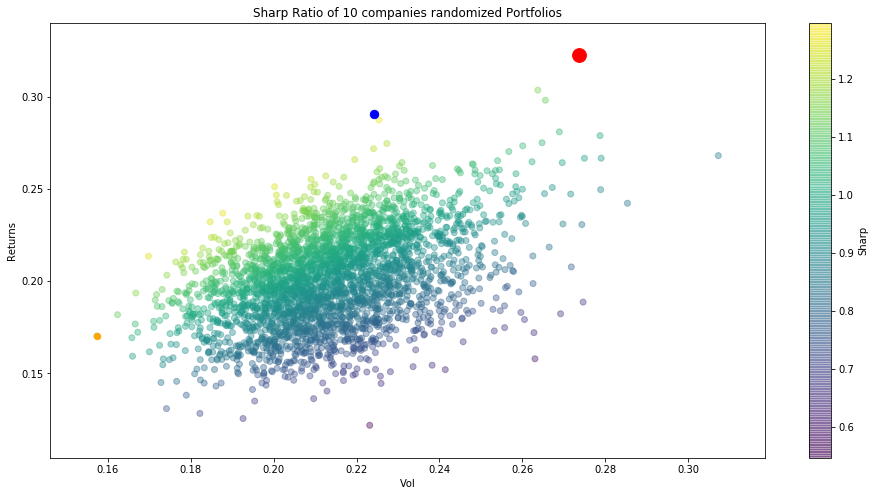

In [107]:
plt.figure(figsize= (16,8))
plt.scatter(all_vol, all_returns, c = all_sharp, alpha=0.4)
plt.colorbar(label = "Sharp")
plt.scatter(all_vol[returns_max], all_returns[returns_max], c = "r", s = 190, label = "Max Return")
plt.scatter(all_vol[vol_low], all_returns[vol_low], c = "orange", s = 40, label  = "Lowest Vol")
plt.scatter(all_vol[sharp_max], all_returns[sharp_max], c = "b", s = 70, label = "Max Sharp")
plt.xlabel("Vol")
plt.ylabel("Returns")
plt.title("Sharp Ratio of 10 companies randomized Portfolios");

### Data Frame 

In [108]:
we = pd.DataFrame(all_weights, columns=['KMB', 'HRL', 'RF', 'WDC', 'MSI', 'DRE', 'AMD', 'KO', 'NFLX', 'NTAP'])

In [109]:
we["ret"] = all_returns

In [110]:
we["vol"] = all_vol

In [111]:
we["sharp"] = all_sharp

In [112]:
we[we["sharp"] == all_sharp[sharp_max]]

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP,ret,vol,sharp
2069,0.052715,0.221408,0.011066,0.013078,0.230781,0.108459,0.077144,0.004724,0.278912,0.001714,0.290728,0.224255,1.296417


In [113]:
we[we["ret"] == all_returns[returns_max]]

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP,ret,vol,sharp
1168,0.079185,0.052246,0.087343,0.003856,0.113561,0.037216,0.104193,0.111136,0.410233,0.00103,0.322426,0.273587,1.178516


### Markowitz Efficient Frontier
- Using Scipy

In [114]:
tickers

['KMB', 'HRL', 'RF', 'WDC', 'MSI', 'DRE', 'AMD', 'KO', 'NFLX', 'NTAP']

In [115]:
from scipy.optimize import minimize

In [116]:
def get_Shrp(weights):
    weights = np.array(weights)
    ret = np.sum(port_daily.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(port_daily.cov() *252, weights)))
    shp = ret/vol
    return np.array([ret,vol,shp])

In [117]:
def check_w(weights):
    return np.sum(weights) - 1

In [118]:
def decrease_Shp(weights):
    return get_Shrp(weights)[2] * -1

In [119]:
initial_guess =  [.1] * len(tickers)

In [120]:
initial_guess

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [121]:
bounds = ((0,1),) * len(tickers)

In [122]:
bounds

((0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1))

In [123]:
cons = {"type": "eq", "fun": check_w}

In [124]:
solution = minimize(decrease_Shp, initial_guess, method="SLSQP", bounds=bounds, constraints=cons)

In [125]:
solution

     fun: -1.401160123250564
     jac: array([ 5.46127558e-05,  1.38029456e-04,  2.93644920e-01,  5.93828604e-01,
        6.25193119e-04,  5.23057580e-02, -3.01301479e-04,  9.90645289e-02,
       -7.36668706e-04,  4.90739629e-01])
 message: 'Optimization terminated successfully.'
    nfev: 111
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.08822367e-01, 5.05624255e-01, 2.96312454e-16, 0.00000000e+00,
       1.43272943e-01, 0.00000000e+00, 3.03025248e-02, 1.38669458e-16,
       2.11977910e-01, 3.87710697e-16])

### Scipy Results 
- Is Esimating we could get a sharp of 1.4

In [126]:
get_Shrp(solution["x"])

array([0.26794237, 0.19122894, 1.40116012])

In [127]:
weights = solution["x"]

In [128]:
suggested_weights = pd.DataFrame(weights).transpose()

In [129]:
suggested_weights.columns = ['KMB', 'HRL', 'RF', 'WDC', 'MSI', 'DRE', 'AMD', 'KO', 'NFLX', 'NTAP']

In [130]:
suggested_weights

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP
0,0.108822,0.505624,2.963125e-16,0.0,0.143273,0.0,0.030303,1.386695e-16,0.211978,3.877107e-16


### Sklearn Results 
- The Results actually tells us that we could produce a portfolio that has a sharp of 1.4 which looks like if we were to eliminate a RF, NTAP from the portfolio
- Lets take a look at the efficient frontier

In [131]:
frontier_y = np.linspace(0.120,0.35,200)

In [132]:
def mini_vol(weights):
    return get_Shrp(weights)[1]

In [133]:
frontier_vol = []

In [134]:
frontier_weights= []

In [135]:
##for pos_return in frontier_y:
 ##   con = ({"type":"eq", "fun": check_w}, {"type":"eq", "fun": lambda w: get_Shrp(w)[0] - pos_return})
   ## result = minimize(mini_vol, initial_guess, method="SLSQP", bounds=bounds, constraints=con)
   ## frontier_vol.append(result["fun"])
   ## frontier_weights.append(result.x)

In [136]:
#result

     fun: 0.26840255903400784
     jac: array([0.05446354, 0.10581715, 0.11603679, 0.14106382, 0.08037518,
       0.09843392, 0.24770538, 0.05500725, 0.46935359, 0.11720365])
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.00000000e+00, 5.07237329e-01, 2.09356200e-18, 0.00000000e+00,
       2.35095641e-17, 0.00000000e+00, 7.46759084e-02, 1.80275669e-17,
       4.18086763e-01, 0.00000000e+00])

In [137]:
len(frontier_vol)

200

In [138]:
len(frontier_y)

200

In [153]:
frontier = pd.read_csv("resources/efficient_frontier_data.csv", index_col="Unnamed: 0")

In [154]:
frontier

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP,returns,vol,sharp
0,3.122602e-01,0.082559,0.000000e+00,1.116728e-17,3.791652e-02,0.000000e+00,8.239937e-18,5.158466e-01,0.000000e+00,5.141725e-02,0.120000,0.150572,0.796959
1,3.104778e-01,0.090486,0.000000e+00,0.000000e+00,4.150899e-02,1.387779e-17,1.268517e-17,5.075978e-01,0.000000e+00,4.992915e-02,0.121156,0.150259,0.806315
2,3.087192e-01,0.098421,3.252607e-18,3.577867e-18,4.508299e-02,0.000000e+00,0.000000e+00,4.993499e-01,1.116728e-17,4.842708e-02,0.122312,0.149964,0.815604
3,3.070357e-01,0.106215,8.673617e-19,8.185726e-18,4.880447e-02,3.523657e-18,8.294147e-18,4.909669e-01,0.000000e+00,4.697771e-02,0.123467,0.149690,0.824819
4,3.057001e-01,0.114920,4.518878e-17,0.000000e+00,5.124559e-02,2.214991e-19,0.000000e+00,4.826832e-01,2.173063e-18,4.545143e-02,0.124623,0.149435,0.833960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000e+00,0.519204,0.000000e+00,8.171165e-17,3.694655e-03,0.000000e+00,7.274003e-02,0.000000e+00,4.043608e-01,0.000000e+00,0.345377,0.263095,1.312747
196,6.703026e-17,0.518213,0.000000e+00,3.353892e-17,7.957382e-04,0.000000e+00,7.342934e-02,0.000000e+00,4.075617e-01,6.198809e-17,0.346533,0.264411,1.310581
197,4.877110e-17,0.515091,0.000000e+00,3.632417e-18,1.820794e-16,0.000000e+00,7.390109e-02,0.000000e+00,4.110077e-01,6.071872e-18,0.347688,0.265734,1.308407
198,0.000000e+00,0.511163,1.542329e-17,0.000000e+00,0.000000e+00,0.000000e+00,7.429112e-02,8.525056e-18,4.145462e-01,3.668774e-17,0.348844,0.267065,1.306217


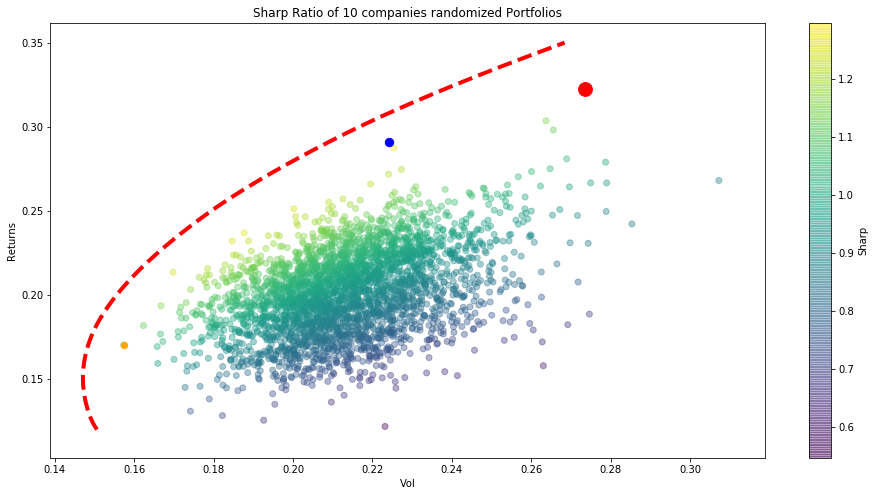

In [155]:
plt.figure(figsize= (16,8))
plt.scatter(all_vol, all_returns, c = all_sharp, alpha=0.4)
plt.plot(frontier["vol"], frontier["returns"], ls = "--", lw = 4, c = "r")
plt.colorbar(label = "Sharp")
plt.scatter(all_vol[returns_max], all_returns[returns_max], c = "r", s = 190, label = "Max Return")
plt.scatter(all_vol[vol_low], all_returns[vol_low], c = "orange", s = 40, label  = "Lowest Vol")
plt.scatter(all_vol[sharp_max], all_returns[sharp_max], c = "b", s = 70, label = "Max Sharp")
plt.xlabel("Vol")
plt.ylabel("Returns")
plt.title("Sharp Ratio of 10 companies randomized Portfolios");

In [140]:
weights_df = pd.DataFrame(frontier_weights)

In [141]:
weights_df.columns = tickers

In [142]:
weights_df["returns"] = frontier_y

In [143]:
weights_df["vol"] = frontier_vol

In [144]:
weights_df

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP,returns,vol
0,3.122602e-01,0.082559,0.000000e+00,1.116728e-17,3.791652e-02,0.000000e+00,8.239937e-18,5.158466e-01,0.000000e+00,5.141725e-02,0.120000,0.150572
1,3.104778e-01,0.090486,0.000000e+00,0.000000e+00,4.150899e-02,1.387779e-17,1.268517e-17,5.075978e-01,0.000000e+00,4.992915e-02,0.121156,0.150259
2,3.087192e-01,0.098421,3.252607e-18,3.577867e-18,4.508299e-02,0.000000e+00,0.000000e+00,4.993499e-01,1.116728e-17,4.842708e-02,0.122312,0.149964
3,3.070357e-01,0.106215,8.673617e-19,8.185726e-18,4.880447e-02,3.523657e-18,8.294147e-18,4.909669e-01,0.000000e+00,4.697771e-02,0.123467,0.149690
4,3.057001e-01,0.114920,4.518878e-17,0.000000e+00,5.124559e-02,2.214991e-19,0.000000e+00,4.826832e-01,2.173063e-18,4.545143e-02,0.124623,0.149435
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000e+00,0.519204,0.000000e+00,8.171165e-17,3.694655e-03,0.000000e+00,7.274003e-02,0.000000e+00,4.043608e-01,0.000000e+00,0.345377,0.263095
196,6.703026e-17,0.518213,0.000000e+00,3.353892e-17,7.957382e-04,0.000000e+00,7.342934e-02,0.000000e+00,4.075617e-01,6.198809e-17,0.346533,0.264411
197,4.877110e-17,0.515091,0.000000e+00,3.632417e-18,1.820794e-16,0.000000e+00,7.390109e-02,0.000000e+00,4.110077e-01,6.071872e-18,0.347688,0.265734
198,0.000000e+00,0.511163,1.542329e-17,0.000000e+00,0.000000e+00,0.000000e+00,7.429112e-02,8.525056e-18,4.145462e-01,3.668774e-17,0.348844,0.267065


In [145]:
weights_df["sharp"] = weights_df["returns"]/weights_df["vol"]

In [156]:
weights_df[weights_df["sharp"] == weights_df["sharp"].max()]

,KMB,HRL,RF,WDC,MSI,DRE,AMD,KO,NFLX,NTAP,returns,vol,sharp
128,0.109133,0.50559,5.149960e-19,9.405454e-18,0.142731,1.707618e-18,0.030691,0.0,0.211855,4.607859e-19,0.26794,0.191227,1.40116


In [157]:
data.loc["A"]

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
AOS,A.O. Smith Corp,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie Inc.,Health Care
ACN,Accenture plc,Information Technology
...,...,...
XYL,Xylem Inc.,Industrials
YUM,Yum! Brands Inc,Consumer Discretionary
ZBH,Zimmer Biomet Holdings,Health Care


KeyError: 'ARNC'

(737425.0, 737567.0)

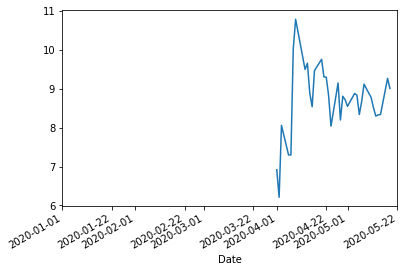

In [163]:
stock_Data["ARNC"].plot()
plt.xlim("2020-1-1", "2020-5-22")

In [167]:
stocks_Corr = stock_Data.pct_change().corr()

In [177]:
stocks_Corr["ARNC"].sort_values(ascending = True)

UTX    -0.483895
NFLX   -0.328149
CLX    -0.248543
TTWO   -0.242818
WMT    -0.230564
          ...   
PX           NaN
SCG          NaN
STI          NaN
TWX          NaN
XL           NaN
Name: ARNC, Length: 485, dtype: float64